In [2]:
import sys

sys.path.append("build/lib.macosx-10.11-intel-2.7")

import basc
import matplotlib.pyplot as plt
import numpy as np

maxatom = 8

# Needed to address a bug re: setting options without any views declared
#blankview = basc.view()

basc.readConfig("config.txt")
basc.setOption("Iseed", 54321)
basc.setOption("Ensemble", 40)

maxindex = 10


In [3]:
myview = []
result = []
for index in range(0,maxindex):
    myview.append(basc.view())
    myview[index].loadPBCor("data/points/simmap{}.alma.cycle2.6.noisy.flux.fits".format(index))
    myview[index].loadMap("data/points/simmap{}.alma.cycle2.6.noisy.image.fits".format(index))
    myview[index].loadBeam("data/points/simmap{}.alma.cycle2.6.noisy.psf.fits".format(index))
    
    print(".")
    sys.stdout.flush()
    
    myview[index].run()
    result.append(myview[index].getChain())

    

IOError: [Errno 2] No such file or directory: 'data/points/simmap0.alma.cycle2.6.noisy.flux.fits'

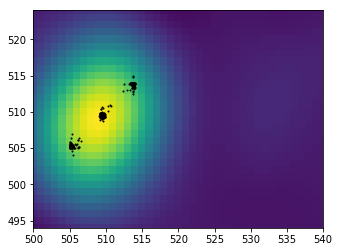

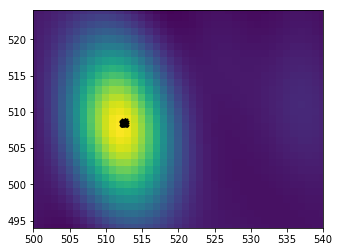

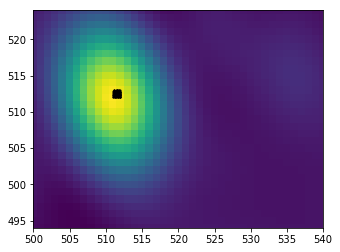

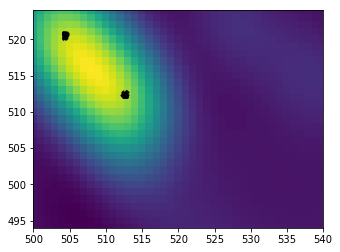

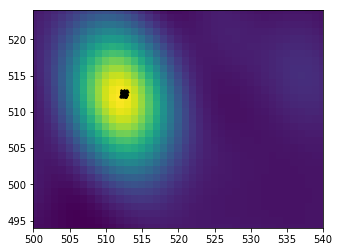

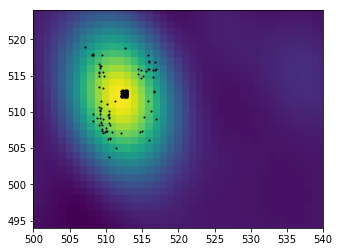

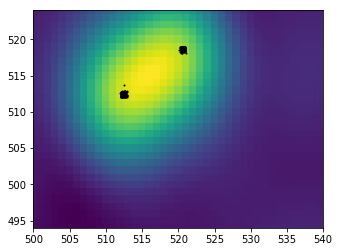

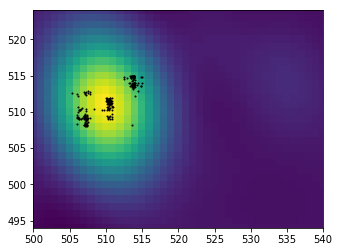

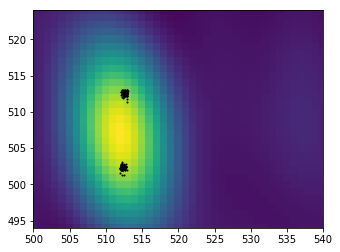

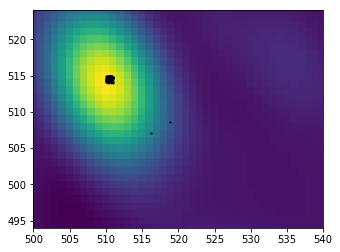

In [3]:
dx = (500,540)
dy = (494,524)

for index in  range(0,maxindex):
    plt.scatter(result[index]['y'], result[index]['x'], s=1, color='black')
    plt.imshow(myview[index].map(0))
    plt.xlim(dx)
    plt.ylim(dy)
    plt.savefig("data/points/scatter{}.png".format(index))
    plt.show()


In [1]:
resultmap, y, x = np.histogram2d(result['x'], result['y'], bins=(range(1024), range(1024)))

plt.imshow(resultmap)
plt.xlim(dx)
plt.ylim(dy)
plt.show()

for n in range(5):
    print(n)
    resultmap, y, x = np.histogram2d(stack[n]['x'], stack[n]['y'], bins=(range(1024), range(1024)))
    plt.imshow(resultmap)
    plt.xlim(dx)
    plt.ylim(dy)
    plt.show()
    print(np.median(stack[n]['x']))
    print(np.median(stack[n]['y']))

NameError: name 'np' is not defined

In [ ]:
Data_original = []
for i in range(1, 8):
    cen_num = i+1
    rows = len(stack[i])//cen_num
    #print (rows)
    for j in range(rows):
        temp = []
        for k in range(cen_num):
            #print (rows, k)
            temp += [stack[i]['x'][j * cen_num + k]] + [stack[i]['y'][j * cen_num + k]] + [stack[i]['F'][j * cen_num + k]] 
        Data_original += [temp]
Data_original = np.array(Data_original)

In [ ]:
Data_c = Data_original
def combine_data(Data):
    """
    Return the coloumn number for each row of Data, and combine every
    point together.
    >>>Data_xy, col_num, flux = conbine_data(Data)
    >>>Data_xy[0] == Data[0,0]
    True
    >>>Data_xy[1] == Data[0,1]
    True
    >>>flux[0] == Data[0,2]
    True
    """
    data_row = len(Data)
    col_num = []
    Data_xy = np.zeros(2)
    flux = np.zeros(1)
    for i in range(data_row):
        col_num += [len(Data[i])]
        for j in range(len(Data[i])//3):
            #print (Data_xy)
            Data_xy = np.append(Data_xy, Data[i][3*j:(3*j+2)])
            flux = np.append(flux, Data[i][3*j + 2])
    return Data_xy[2:], col_num, flux[1:]

Data_xy, col_num, flux = combine_data(Data_c)
flux = 1./(1-flux) - 1  # F = r/(1-r) = -1 + 1./(1 - r)
atom_mean = np.ceil(np.mean(col_num))/3
atom_max = int(np.max(col_num))//3
Data_vxy = np.reshape(Data_xy, (len(Data_xy)//2, 2))


In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

def find_center(Data, atom_max, min_samples = 10, eps = 5):
    """
    find the centers for each data set using DBSCAN.
    Data should be a n*2 array.
    """
    while(eps and min_samples):
        db = DBSCAN(eps, min_samples).fit(Data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        atom = len(set(labels)) - (1 if -1 in labels else 0) # number of atoms
        print ('We find', atom, 'atoms')
        if atom > atom_max:
            print ('You need to increase the variable: min_samples')
            print (atom, 'is even bigger than the possible biggest atom number', atom_max)
        unique_labels = set(labels)
        noise_label = (labels == -1)
        noise = Data[noise_label & ~core_samples_mask]
        if len(noise) == 0:
            print ('There is no outlier.')
        else:
            print ('There are', len(noise), 'outliers. Please have a look at them.')
            plt.scatter(noise[:,0], noise[:,1])
            plt.title('Outliers')
            #plt.xlim([0,1])
            #plt.ylim([0,1])
            plt.axis('equal')
            plt.show()
        print ("You can change the variables: eps and min_samples")
        print ("Please increase eps if you get too many atoms or there are outliers")
        print ("Please increase min_samples if you get too many atoms")
        eps_new = eps
        min_samples_new = min_samples
        print ('You chose eps =', eps_new, 'and min_samples =', min_samples_new)
        eps = float(input("Type in the new eps that you want to test(0 to stop): "))
        min_samples = int(input("Type in the new min_samples that you want to test(0 to stop): "))
    xy = []
    centers = np.zeros((atom,2))
    for k in range(atom):
        class_member_mask = (labels == k)
        xy += [Data[class_member_mask & core_samples_mask]]
        centers[k] = np.mean(Data[class_member_mask & core_samples_mask], axis = 0)
    print ('The', atom, 'cluster centers are \n', centers)
    return atom, xy, noise, labels, centers, eps_new, min_samples_new

def find_center_mul(Data_vxy, atom_max, onemore = 'y'):
    """
    find the centers many times until you are happy.
    """
    eps_new = 5
    min_samples_new = 10
    while onemore == 'y' or onemore == 'Y':
        atom, xy, noise, labels, centers, eps_new, min_samples_new = find_center(Data_vxy, atom_max, min_samples_new, eps_new)
        col = ['b', 'g', 'r', 'c', 'm'] * atom
        fig = plt.figure()
        for i in range(atom):
            l1 = plt.scatter(xy[i][:,0], xy[i][:,1], s = 30)
            l2 = plt.scatter(centers[:,0], centers[:,1], c = 'k', s = 5)
            l3 = plt.scatter(noise[:,0], noise[:,1], c = 'r', s = 2)
            plt.grid(True)
            #plt.xlim(0, 1)
            #plt.ylim(0, 1)
            plt.axes().set_aspect('equal', 'datalim')
        plt.title('Clustering of the MCMC result (samples_1.csv) for Sim')
        plt.xlabel('Image plane x axis')
        plt.ylabel('Image plane y axis')
        plt.legend((l1, l2, l3),
           ('Clusters', 'Centers', 'Noise'),
           ncol=3,
           fontsize=8)
        fig.savefig('result_1.png')
        plt.show()
        onemore = str(input("Do you want to try one more time to find the cluster?(y/n)\n"))
    return atom, xy, noise, labels, centers

atom, xy, noise, labels, centers = find_center_mul(Data_vxy, atom_max)

NameError: name 'Data_vxy' is not defined

In [ ]:
plt.subplot(121)
plt.scatter(xy[0][:,0], xy[0][:,1])
plt.xlim(400, 600)
plt.ylim(400, 600)
plt.subplot(122)
plt.scatter(xy[0][:,0], xy[0][:,1])
plt.show()

In [ ]:
m1 = len(noise)
m2 = len(Data_original)
Data_nonnoise = Data_original
for i in range(m1):
    for j in range(m2):
        if (noise[i][0] in Data_original[j]) and (noise[i][1] in Data_original[j]):
            #print (noise[i][0], Data_original[j])
            temp = Data_original[j].index(noise[i][0])
            #print (i,j,temp,temp+2)
            del Data_nonnoise[j][temp]
            del Data_nonnoise[j][temp]
            del Data_nonnoise[j][temp]

In [ ]:
def distance(point1, point2):
    """
    Euclidean distance from point1 and point2
    >>>distance([0.1, 0.1], [0.2, 0.1])
    >>>0.1
    >>>distance([0.2, 0.1], [0.2, 0.1])
    >>>0.0
    """
    return np.abs((point1[0] - point2[0]) + complex(0,1)*(point1[1]- point2[1]))

def dis_matrix(Data, centers):
    """
    It will return the distance matrix for each row of data and the centers
    """
    m = len(Data)//3
    n = len(centers)
    matrix = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            matrix[i,j] = distance([Data[3*i], Data[3*i+1]],centers[j])
    return matrix

def distance_rank(Data, centers):
    index = []
    for i in range(len(Data)):
        matrix = dis_matrix(Data[i], centers)
        matrix = matrix.tolist()
        index += [[matrix[i].index(min(matrix[i])) for i in range(len(matrix))]]
    return index

swap_index = distance_rank(Data_nonnoise, centers)


In [ ]:
def swap_data(swap_index, Data, atom):
    """
    Swap the original data according to swap_index and generate data which belongs
    to relevant centers.
    """
    Data_swapped = []
    for i in range(atom):
        Data_swapped += Data[swap_index.index(i)*3:swap_index.index(i)*3+3]
    return Data_swapped

Data_output = []
for i in range(len(Data_nonnoise)):
    Data_output += [swap_data(swap_index[i], Data_nonnoise[i], atom)]


In [ ]:
Data_output

In [ ]:
Data_output_xy, col_output_num, flux_output = combine_data(Data_output)
#flux_output = 1./(1-flux_output) - 1  # F = r/(1-r) = -1 + 1./(1 - r)
Data_output_vxy = np.reshape(Data_output_xy, (len(Data_output_xy)//atom//2, atom*2))
flux_output = np.reshape(flux_output, (len(flux_output)//atom, atom))
xy_mean = np.mean(Data_output_vxy, axis = 0)
xy_var = np.var(Data_output_vxy, axis = 0)
flux_mean = np.mean(flux_output, axis = 0)
flux_var = np.var(flux_output, axis = 0)
xy_mean, xy_var, flux_mean, flux_var, centers

In [ ]:
plt.scatter(centers[:,1],centers[:,0])
plt.imshow(dmap)
plt.xlim(500,540)
plt.ylim(494,524)
plt.show()
centers[:,1]

In [ ]:
Data_original

In [ ]:
for y in [508,509,510,511,512,513,514,515,516]:
    for x in [508,509,510,511,512,513,514,515,516]:
        print '%7.7f' % pbcor[x,y],
    print("\n")